# Oil Palm Disease Detection

## Data Acquisition

Data collected from kaggle private dataset. The data was manually selected to 1000 out of a total of about 3000 images each class. Follow these steps:

0. Download the dataset and extract it.
1. Create `data` folder and put the extracted folder in here. `data` folder should now have 1 folder named `selected_dataset` inside.
2. Follow the code.

In [5]:
import os
import shutil

SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [ ]:
def copy_selected(label: str) -> None:
    with open(f'selected_data_{label}.txt', 'r') as f:
        selected_list = [x.strip() for x in f.readlines()]
    for image_file in selected_list:
        src = os.path.join(ORIGINAL_DATA, label, image_file)
        dst = os.path.join(SELECTED_DATA, label, image_file)
        shutil.copyfile(src, dst)


copy_selected('normal')
copy_selected('infected')

## Preprocessing Image

Preprocessing image consist of image enhancing using histogram equalization and noise removal using bilateral smoothing filter.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Union
import sys

In [9]:
def enhance(image: Union[str, np.ndarray], display: bool = False) -> np.ndarray:
    """
    Enhance image by using adaptive histogram equalization
    :param display: bool, if true then return converted image in RGB, if not, return as BGR because it needs to continue to another preprocessing
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of enhance image
    """
    if type(image) is str:
        image = cv2.imread(image)
    # convert from BGR to YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    # create clahe object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # equalize the histogram of the Y channel
    ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
    # convert the YCR_CB image back to RGB format
    if display:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    else:
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR)

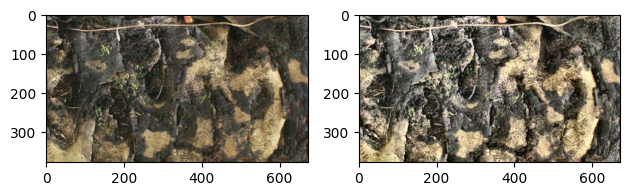

In [10]:
# cv2.imwrite('data/samples/equalized_img.jpg', enhance('data/selected_dataset/normal/DSC03977_4.JPG'))
# cv2.waitKey(0)
def compare_image(image: str, processed_image: np.ndarray):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(Image.open(image))
    ax[1].imshow(processed_image)
    plt.tight_layout()


compare_image(SAMPLE_IMAGE, enhance(SAMPLE_IMAGE, display=True))

In [11]:
def remove_noise(image: Union[str, np.ndarray], filter: str = 'bilateral', display: bool = False) -> np.ndarray:
    """
    Remove noise from image using bilateral filter
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    # apply bilateral filter with d = 15, sigmaColor = sigmaSpace = 75.

    if filter == 'bilateral':
        filtered_image = cv2.bilateralFilter(image, 10, 65, 65)
    elif filter == 'median':
        filtered_image = cv2.medianBlur(image, 5)
    else:
        raise ValueError('Unrecognized filter')

    if display:
        return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    return filtered_image

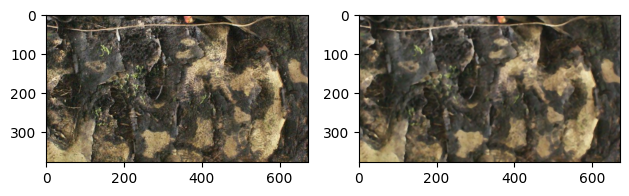

In [12]:
compare_image(SAMPLE_IMAGE, remove_noise(SAMPLE_IMAGE, filter='median', display=True))

In [13]:
def resize(image: Union[str, np.ndarray], size: int = 256) -> np.ndarray:
    """
    Resize image
    :param image: [str, np.ndarray], path to image file or image array in numpy array
    :param size: int, size of image
    :return: np.ndarray, numpy array of image with removed noise
    """
    if type(image) is str:
        image = cv2.imread(image)
    resized_image = cv2.resize(image, (size, size))
    return resized_image

### Apply preprocessing

In [14]:
if not os.path.exists(PROCESSED_DATASET):
    os.makedirs(PROCESSED_DATASET)

for image_class in os.listdir(SELECTED_DATA):
    if not os.path.exists(os.path.join(PROCESSED_DATASET, image_class)):
        os.makedirs(os.path.join(PROCESSED_DATASET, image_class))
    for image_file in os.listdir(os.path.join(SELECTED_DATA, image_class)):
        image_path = os.path.join(SELECTED_DATA, image_class, image_file)
        image = enhance(image_path)
        image = remove_noise(image, filter='median')
        image = resize(image)
        sys.stdout.write(f"\rWriting {image_file} to {PROCESSED_DATASET}")
        sys.stdout.flush()
        cv2.imwrite(os.path.join(PROCESSED_DATASET, image_class, image_file), image)

Writing DSC04873_9.JPG to data\processed_dataset

## Feature Extraction

Feature extraction using LBP, Color moments, and Hu-moments.

In [3]:
import cv2
from skimage import io, exposure
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from skimage.measure import shannon_entropy
import numpy as np
from typing import Union
from scipy.stats import kurtosis, skew
import pandas as pd
import matplotlib.pyplot as plt

### GLCM

In [13]:
list(range(0, 360, 45))

[0, 45, 90, 135, 180, 225, 270, 315]

In [8]:
def glcm_add_features(glcmatrix: np.ndarray, prop: str):
    add_features_map = {'mean': np.mean,
                        'std': np.std,
                        'entropy': shannon_entropy,
                        'variance': np.var,
                        'kurtosis': kurtosis,
                        'skewness': skew}
    temp_arr = np.zeros((glcmatrix.shape[3],))
    for angle in range(glcmatrix.shape[3]):
        if prop == 'kurtosis' or prop == 'skewness':
            temp_arr[angle] = add_features_map[prop](glcmatrix[:,:,0,angle], axis=None)
        else:
            temp_arr[angle] = add_features_map[prop](glcmatrix[:,:,0,angle])

    return temp_arr

def create_glcm_series(features, angles, props):
    series = pd.Series(np.array(features).ravel(),
                       index=[f'{y}_{x}' for y in props for x in angles])
    return series

In [9]:
def glcm(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate GLCM of an image
    :param image:
    :return:
    """
    angles = [0, 45, 90, 135]
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    add_properties = ['mean', 'std', 'entropy', 'variance', 'kurtosis', 'skewness']
    glcm_features = []
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    glcmatrix = graycomatrix(image, distances=[1], angles=angles, normed=True)
    for prop in properties:
        glcm_features.append(graycoprops(glcmatrix, prop)[0])
    for prop in add_properties:
        temp_arr = glcm_add_features(glcmatrix, prop)
        glcm_features.append(temp_arr)

    glcm_series = create_glcm_series(glcm_features, angles, properties+add_properties)

    return glcm_series

glcm(SAMPLE_IMAGE)

contrast_0           2.380511e+02
contrast_45          4.084531e+02
contrast_90          2.295032e+02
contrast_135         2.380511e+02
dissimilarity_0      9.988326e+00
dissimilarity_45     1.325122e+01
dissimilarity_90     9.725902e+00
dissimilarity_135    9.988326e+00
homogeneity_0        1.245942e-01
homogeneity_45       9.644646e-02
homogeneity_90       1.302449e-01
homogeneity_135      1.245942e-01
ASM_0                2.400195e-04
ASM_45               1.857250e-04
ASM_90               2.527668e-04
ASM_135              2.400195e-04
energy_0             1.549256e-02
energy_45            1.362810e-02
energy_90            1.589864e-02
energy_135           1.549256e-02
correlation_0        9.376147e-01
correlation_45       8.929857e-01
correlation_90       9.398401e-01
correlation_135      9.376147e-01
mean_0               1.525879e-05
mean_45              1.525879e-05
mean_90              1.525879e-05
mean_135             1.525879e-05
std_0                5.856259e-05
std_45        

### LBP

In [10]:
def lbp(image: Union[np.ndarray, str], radius: int = 3, n_points: int = 8, methods: str = 'uniform') -> pd.Series:
    """
    Calculate Local Binary Pattern of an image.
    :param image: input image
    :param radius: radius of LBP
    :param n_points: number of points
    :param methods: methods to use for LBP
    :return: LBP histogram
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(image, n_points, radius, method=methods)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-7)

    lbp_series = pd.Series(hist.astype('float'),
                           index=[f'lbp_{x}' for x in range(1, len(hist)+1)])
    return lbp_series


lbp(SAMPLE_IMAGE)

lbp_1     0.081692
lbp_2     0.097183
lbp_3     0.065791
lbp_4     0.068409
lbp_5     0.076420
lbp_6     0.065858
lbp_7     0.063527
lbp_8     0.096285
lbp_9     0.090026
lbp_10    0.294808
dtype: float64

### HOG

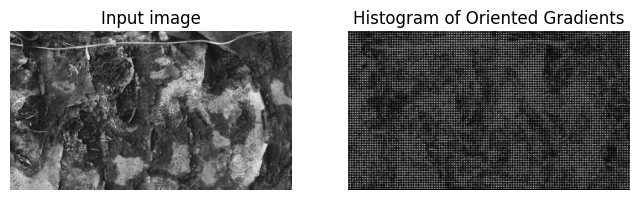

hog_1         0.082770
hog_2         0.000000
hog_3         0.000000
hog_4         0.000000
hog_5         0.120706
                ...   
hog_559112    0.311578
hog_559113    0.058295
hog_559114    0.174918
hog_559115    0.213553
hog_559116    0.000000
Length: 559116, dtype: float64

In [7]:
def hog_feature(image: Union[str, np.ndarray], visualize=False):
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        # image = io.imread(image)
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # sliding window 16 36
    fd_hog_image = hog(image, pixels_per_cell=(4,4), cells_per_block=(2,2), visualize=visualize)

    if visualize:
        fd, hog_image = fd_hog_image
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()
    else:
        fd = fd_hog_image

    hog_series = pd.Series(fd, index=[f'hog_{x}' for x in range(1, len(fd)+1)])
    return hog_series

hog_feature(SAMPLE_IMAGE, visualize=True)

### Color Moment

In [5]:
def color_moment(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate color moment of an image (mean, standard deviation, skewness, kurtosis).
    :param image: input image
    :return: color moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = io.imread(image)
    # mean of each channel
    mean = np.mean(image, axis=(0, 1))
    # standard deviation of each channel
    std = np.std(image, axis=(0, 1))
    # skewness of each channel
    skewness = np.array([
        skew(image[:,:,0], axis=None),
        skew(image[:,:,1], axis=None),
        skew(image[:,:,2], axis=None)
    ])
    # kurtosis of each channel
    kurt = np.array([
        kurtosis(image[:,:,0], axis=None),
        kurtosis(image[:,:,1], axis=None),
        kurtosis(image[:,:,2], axis=None)
    ])
    color_moment_series = pd.Series(
        np.concatenate((mean, std, skewness, kurt)),
        index=[f'{moment}_{channel}' for channel in ['R', 'G', 'B'] for moment in ['mean', 'std', 'skew', 'kurt']]
    )

    return color_moment_series


color_moment(SAMPLE_IMAGE)

mean_R    92.328987
std_R     83.876531
skew_R    67.206853
kurt_R    49.266753
mean_G    43.049632
std_G     34.402919
skew_G     0.882377
kurt_G     0.958502
mean_B     0.939766
std_B     -0.055151
skew_B     0.297217
kurt_B     0.739102
dtype: float64

### Color Histogram (HSV)

In [11]:
def color_histogram(image: Union[str, np.ndarray], bins=8, mask=None):
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)

    hist_series = pd.Series(hist.flatten(),
                            index=[f'hist_{x}' for x in range(1, len(hist.flatten())+1)])
    return hist_series

color_histogram(SAMPLE_IMAGE)

hist_1      0.008224
hist_2      0.097642
hist_3      0.186774
hist_4      0.070209
hist_5      0.025053
              ...   
hist_508    0.000000
hist_509    0.000000
hist_510    0.000000
hist_511    0.000000
hist_512    0.000000
Length: 512, dtype: float32

### Hu-Moment

In [12]:
def hu_moment(image: Union[np.ndarray, str]) -> pd.Series:
    """
    Calculate Hu moment of an image.
    :param image: input image
    :return: Hu moment
    """
    if image is None:
        raise ValueError("image is None")
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # compute moments
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    hu_moment_series = pd.Series(moments,
                                 index=[f'humoment_{x+1}' for x in range(len(moments))])
    return hu_moment_series


hu_moment(SAMPLE_IMAGE)

humoment_1    2.303527e-03
humoment_2    1.366589e-06
humoment_3    7.302309e-11
humoment_4    7.990320e-11
humoment_5    4.038724e-21
humoment_6    8.807210e-14
humoment_7   -4.576131e-21
dtype: float64

### Combine all features

In [7]:
def generate_header():
    lbp_columns = [f'lbp_{x}' for x in range(1, 11)]
    color_columns = []
    for moments in ['mean', 'std', 'skew', 'kurt']:
        for color_channel in ['R', 'G', 'B']: color_columns.append(f'{moments}_{color_channel}')
    hu_moment_columns = [f'humoment_{x}' for x in range(1, 8)]
    return ['is_infected'] + lbp_columns + color_columns + hu_moment_columns

In [16]:
# combine all feature
def extract_feature(data_path: str, csv_name: str) -> str:
    """
    Extract feature from images in data_path and save it to csv.
    The extracted feature is texture (LBP), color (color moment), shape (hu-moment)
    :param data_path: str, the path to where the classes folder is
    :param csv_name: str, the name of the csv file
    :return: str, path to csv file containing extracted feature of all image
    """
    df = pd.DataFrame()

    class_map = {'infected': 1, 'normal': 0}
    for image_class in os.listdir(os.path.join(data_path)):
        print(f'Extracting {image_class} class')
        for image_file in os.listdir(os.path.join(data_path, image_class)):
            image_path = os.path.join(data_path, image_class, image_file)
            extracted_lbp = lbp(image_path)
            extracted_glcm = glcm(image_path)
            # extracted_hog = hog_feature(image_path)
            # extracted_color_moment = color_moment(image_path)
            extracted_histogram = color_histogram(image_path)
            extracted_humoment = hu_moment(image_path)
            series_concat = pd.concat([extracted_lbp,
                                       extracted_glcm,
                                       extracted_histogram,
                                       extracted_humoment])
            series_concat['is_infected'] = class_map[image_class]

            if not df.shape[0]:
                df = pd.DataFrame(series_concat).transpose()
                continue

            df.loc[len(df)] = series_concat

    df.to_csv(os.path.join('data', f'{csv_name}.csv'), index=False)
    df.to_excel(os.path.join('data', 'excel', f'{csv_name}.xlsx'), index=False)

    return df

In [17]:
processed_img_feature = extract_feature(PROCESSED_DATASET, 'processed_img_feature')
orig_img_feature = extract_feature(SELECTED_DATA, 'orig_img_feature')

Extracting infected class
Extracting normal class
Extracting infected class
Extracting normal class


## Feature Selection

The final feature which will be classified later for comparison is following this pattern.

- Color
- Texture
- Shape
- Color-texture
- Color-shape
- Texture-shape
- Color-texture-shape
- Color-texture-shape (feature selection)

Therefore, we apply feature selection only on the whole feature set. The feature selection method consist of.

- PCA
- Mutual Information
- SelectFromModel

In [19]:
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [20]:
proc_img_df = pd.read_csv(os.path.join('data', 'processed_img_feature.csv'))
orig_img_df = pd.read_csv(os.path.join('data', 'orig_img_feature.csv'))

orig_img_df.head(2)

,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,lbp_10,...,hist_511,hist_512,humoment_1,humoment_2,humoment_3,humoment_4,humoment_5,humoment_6,humoment_7,is_infected
0,0.078330,0.093329,0.067574,0.071059,0.086876,0.071854,0.063579,0.095214,0.087900,0.284285,...,0.0,0.0,0.002660,0.000002,5.056881e-10,1.996583e-10,5.404732e-20,2.542200e-13,-3.322191e-20,1.0
1,0.073326,0.089349,0.066693,0.079156,0.116445,0.077405,0.065956,0.091211,0.080011,0.260448,...,0.0,0.0,0.002124,0.000001,5.481881e-11,1.635459e-10,1.515469e-20,1.691927e-13,-3.183560e-21,1.0


In [21]:
# separate the feature and label
proc_img_label = proc_img_df.pop('is_infected')
orig_img_label = orig_img_df.pop('is_infected')

### PCA

Text(0, 0.5, 'cumulative explained variance')

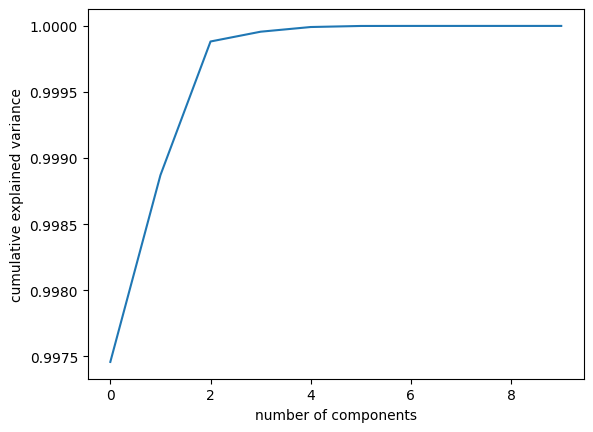

In [27]:
# determine the number of components
pca = PCA().fit(proc_img_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [28]:
def calculate_pca(feature_df, n_components):
    pca = PCA(n_components=n_components)
    reduced_feature = pca.fit_transform(feature_df)
    return reduced_feature

In [29]:
reduced_proc_img = calculate_pca(proc_img_df, 2)
reduced_proc_img

array([[-1777.65369992,   -51.97625555],
       [-1772.43951365,    90.92542394],
       [-1775.0825869 ,    -5.19482195],
       ...,
       [-1748.90145988,  -122.07848002],
       [-1611.10891755,   -86.55119136],
       [-1776.2430414 ,     9.57428079]])

In [30]:
reduced_orig_img = calculate_pca(orig_img_df, 2)
reduced_orig_img

array([[-2493.20016831,   -24.94462136],
       [-2527.92144421,   -28.97809591],
       [-2499.70728933,   -27.25280951],
       ...,
       [-2368.91860577,   -12.4997854 ],
       [-2140.22357097,    31.90559706],
       [-2506.50842564,   -25.97505729]])

In [31]:
def export_reduced_feature(df: Union[np.ndarray, pd.DataFrame], filename, header=None):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df, columns=header)
    df.to_csv(os.path.join('data', f'{filename}.csv'), index=False)
    df.to_excel(os.path.join('data', 'excel', f'{filename}.xlsx'), index=False)

In [32]:
def generate_pca_header(array):
    return [f'pca_{x}' for x in range(1, array.shape[1] + 1)]

In [33]:
export_reduced_feature(reduced_proc_img,
                       'reduced_processed_img_features_PCA',
                       generate_pca_header(reduced_proc_img))
export_reduced_feature(reduced_orig_img,
                       'reduced_orig_img_features_PCA',
                       generate_pca_header(reduced_orig_img))

### Mutual Information

In [34]:
mi = mutual_info_classif(proc_img_df, proc_img_label)
mi

array([0.        , 0.02044464, 0.07113869, 0.01562591, 0.        ,
       0.00913483, 0.02409286, 0.01157332, 0.00586975, 0.        ,
       0.02522403, 0.        , 0.0145416 , 0.02522403, 0.04001801,
       0.00342716, 0.        , 0.04014857, 0.01731456, 0.03283884,
       0.01228582, 0.01731456, 0.02463884, 0.02920128, 0.01985013,
       0.02509658, 0.02461411, 0.02929329, 0.01963082, 0.02461411,
       0.02252849, 0.        , 0.        , 0.02252849, 0.01064213,
       0.00175072, 0.00716351, 0.        , 0.02504745, 0.02908853,
       0.01951971, 0.02504745, 0.0508528 , 0.04118271, 0.02879254,
       0.0508528 , 0.02452991, 0.02883818, 0.01980847, 0.02453884,
       0.01267314, 0.02627298, 0.        , 0.01267314, 0.014825  ,
       0.01624908, 0.        , 0.014825  , 0.        , 0.00642461,
       0.01688193, 0.0156905 , 0.00514145, 0.03468149, 0.10828261,
       0.05786373, 0.00286784, 0.0039498 , 0.        , 0.01486423,
       0.0120891 , 0.04874755, 0.09556745, 0.07274711, 0.00735

In [35]:
def calculate_mutual_information(feature_df, label, threshold=0.05):
    mi = mutual_info_classif(feature_df, label)
    selected_column_index = np.where(mi > threshold)
    return feature_df.iloc[:,  selected_column_index[0]]

In [38]:
reduced_proc_img_features_mi = calculate_mutual_information(
    proc_img_df,
    proc_img_label
)
reduced_orig_img_features_mi = calculate_mutual_information(
    orig_img_df,
    orig_img_label
)
reduced_orig_img_features_mi

,hist_5,hist_6,hist_7,hist_12,hist_13,hist_14,hist_15,hist_20,hist_21,hist_22,hist_29,hist_70,hist_71
0,0.005714,0.001696,0.000590,0.155950,0.043517,0.015722,0.020736,0.278888,0.148208,0.067828,0.168999,0.000571,0.000553
1,0.004416,0.003660,0.004018,0.119616,0.049454,0.035728,0.031093,0.397840,0.341483,0.171338,0.233703,0.003998,0.011856
2,0.002919,0.002006,0.004290,0.059717,0.020852,0.025877,0.055209,0.096318,0.065436,0.252570,0.311572,0.000973,0.002343
3,0.015538,0.009374,0.002768,0.164572,0.067333,0.039687,0.010444,0.189824,0.061576,0.036409,0.072394,0.000577,0.000051
4,0.021008,0.009735,0.005899,0.357908,0.156515,0.052607,0.016997,0.411001,0.344902,0.098925,0.067949,0.003135,0.006756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.001120,0.000992,0.001183,0.007595,0.007659,0.008320,0.005712,0.016399,0.011615,0.006654,0.009682,0.000000,0.000013
1996,0.000000,0.000000,0.000014,0.000115,0.000359,0.000833,0.001766,0.001450,0.001450,0.001407,0.003087,0.000000,0.000014
1997,0.004948,0.014684,0.035744,0.032627,0.040311,0.056061,0.039124,0.092167,0.051494,0.031078,0.088667,0.002333,0.004727
1998,0.008764,0.004017,0.001055,0.037472,0.014222,0.008785,0.006391,0.048489,0.026740,0.018665,0.049219,0.000000,0.000122


In [39]:
export_reduced_feature(reduced_proc_img_features_mi, 'reduced_processed_img_features_mi')
export_reduced_feature(reduced_orig_img_features_mi, 'reduced_orig_img_features_mi')

### SelectFromModel

We are using SVM-FS. There isn't specific library for SVM-based feature selection out-of-the-box. But we can use `SelectFromModel` from scikit-learn.

In [40]:
def calculate_svmfs(feature_df: pd.DataFrame, label):
    clf = svm.SVC(kernel='linear')
    selector = SelectFromModel(clf, prefit=False)
    selector.fit(feature_df, label)
    selected_feature = selector.transform(feature_df)
    mask = np.isin(feature_df.values, selected_feature)
    index_column = np.where(np.all(mask, axis=0))
    return feature_df.iloc[:, index_column[0]]

In [41]:
reduced_proc_img_features_svmfs = calculate_svmfs(proc_img_df, proc_img_label)
reduced_orig_img_features_svmfs = calculate_svmfs(orig_img_df, orig_img_label)
reduced_proc_img_features_svmfs

,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_90,...,hist_503,hist_504,hist_505,hist_506,hist_507,hist_508,hist_509,hist_510,hist_511,hist_512
0,0.075699,0.092209,0.127304,0.095963,0.073929,12.409252,13.893349,8.780499,12.409252,0.148635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.068130,0.084000,0.133667,0.087433,0.071640,14.496155,18.372611,11.697794,14.496155,0.130378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.070694,0.076965,0.090454,0.072296,0.064896,14.093612,15.681830,9.204871,14.093612,0.141263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.066666,0.068558,0.090012,0.072037,0.067642,13.861091,15.207228,9.985110,13.861091,0.133831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.069199,0.077972,0.108795,0.082626,0.068939,14.038051,16.010581,9.521094,14.038051,0.140810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.076447,0.092194,0.135712,0.091537,0.072891,9.045067,10.198739,5.317111,9.045067,0.224814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.080399,0.110489,0.149704,0.102280,0.078217,8.436933,10.895317,6.295787,8.436933,0.196375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.077789,0.126587,0.202316,0.124893,0.078476,10.373882,11.398631,6.890165,10.373882,0.187348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.066452,0.084915,0.140182,0.096725,0.075836,12.046078,13.492180,8.665012,12.046078,0.177672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
export_reduced_feature(reduced_proc_img_features_svmfs, 'reduced_processed_img_features_svmfs')
export_reduced_feature(reduced_orig_img_features_svmfs, 'reduced_orig_img_features_svmfs')

## Classification

In [1]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import pandas as pd
import os
import itertools
import glob
import re
from typing import Callable

In [3]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
metrics = ['f1', 'recall', 'precision', 'accuracy']
classifiers = ['knn', 'nb', 'rf']

In [4]:
def classify_with_svm(X: np.ndarray, y: np.ndarray, kernel: str, scoring=metrics):
    pipe = Pipeline([
        ('normalize', MinMaxScaler()),
        ('classify', svm.SVC(kernel=kernel))
    ])
    result = cross_validate(pipe, X=X, y=y, cv=10, scoring=scoring)
    return result

In [5]:
def classify(X: np.ndarray, y: np.ndarray, classifier: Callable, scoring):
    pipe = Pipeline([
        ('normalize', MinMaxScaler()),
        ('classify', classifier)
    ])
    result = cross_validate(pipe, X, y, cv=10, scoring=scoring)
    return result

### All features combination

In [6]:
def create_dataframe(all_feat_comb, classifiers):
    # create fancy multi-column table

    all_feat_comb_merged = []
    for feat in all_feat_comb:
        if isinstance(feat, str):
            all_feat_comb_merged.append(feat)
        else:
            all_feat_comb_merged.append('-'.join(feat))

    index = pd.MultiIndex.from_product([all_feat_comb_merged, metrics])
    df = pd.DataFrame([], index=classifiers, columns=index)
    return df

In [7]:
os.mkdir('result')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'result'

In [8]:
def train_combination(all_classifiers, all_feat_comb, features, feature_df, y, comparison_df, fancy_df, use_svm=True):
    classifiers_map = {'knn': KNeighborsClassifier(3),
                       'nb': GaussianNB(),
                       'rf': RandomForestClassifier()}

    for classifier in all_classifiers:
        for feature in all_feat_comb:
            if not isinstance(feature, str):
                feat_col_name = []
                name = []
                for i in range(len(feature)):
                    feat_col_name += features[feature[i]]
                    name.append(feature[i])
                name = '-'.join(name)
            else:
                feat_col_name = features[feature]
                name = feature
            X = feature_df.loc[:, feat_col_name]
            # print(name)
            # print(X.columns, classifier)
            if use_svm:
                result = classify_with_svm(X, y, kernel=classifier)
            else:
                result = classify(X, y, classifiers_map[classifier], scoring=metrics)

            comparison_df.loc[len(comparison_df.index)] = [
                f'{name}_{classifier}',
                result['fit_time'].mean(),
                result['test_f1'].mean(),
                result['test_recall'].mean(),
                result['test_precision'].mean(),
                result['test_accuracy'].mean()
            ]
            fancy_df.loc[classifier, name] = [result['test_f1'].mean(),
                                              result['test_recall'].mean(),
                                              result['test_precision'].mean(),
                                              result['test_accuracy'].mean()]

    return comparison_df, fancy_df

In [11]:
49+512

561

In [17]:

def compare_combined_feature(filename, use_svm: bool, classifiers_or_kernels=kernels):
    columns = ['names', 'fit_time'] + metrics
    comparison_df = pd.DataFrame(columns=columns)

    feature_file = os.path.join('data', filename)
    feature_df = pd.read_csv(feature_file)
    y = feature_df.pop('is_infected')

    features = {'texture': feature_df.columns[:58].to_list(),
                'color': feature_df.columns[58:58+512].to_list(),
                'shape': feature_df.columns[58+512:].to_list()}
    all_feat_comb = list(features.keys())
    all_feat_comb += list(itertools.combinations(all_feat_comb, 2))
    all_feat_comb += [tuple(features.keys())]

    fancy_df = create_dataframe(all_feat_comb, classifiers_or_kernels)

    comparison_df, fancy_df = train_combination(classifiers_or_kernels, all_feat_comb,
                                                features, feature_df, y,
                                                comparison_df, fancy_df, use_svm=use_svm)

    # export basic dataframe to csv
    if use_svm:
        export_name = os.path.join('result', filename.split('_')[0] + '_classification_result')
    else:
        export_name = os.path.join('result', filename.split('_')[0] + '_classfication_classifiers_result')
    comparison_df.to_csv(export_name + '.csv', index=False)
    # export fancy dataframe to excel
    fancy_df.to_excel(export_name + '.xlsx')

    comparison_df.set_index('names').iloc[:, 1:]\
        .plot\
        .bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

#### SVM Kernels

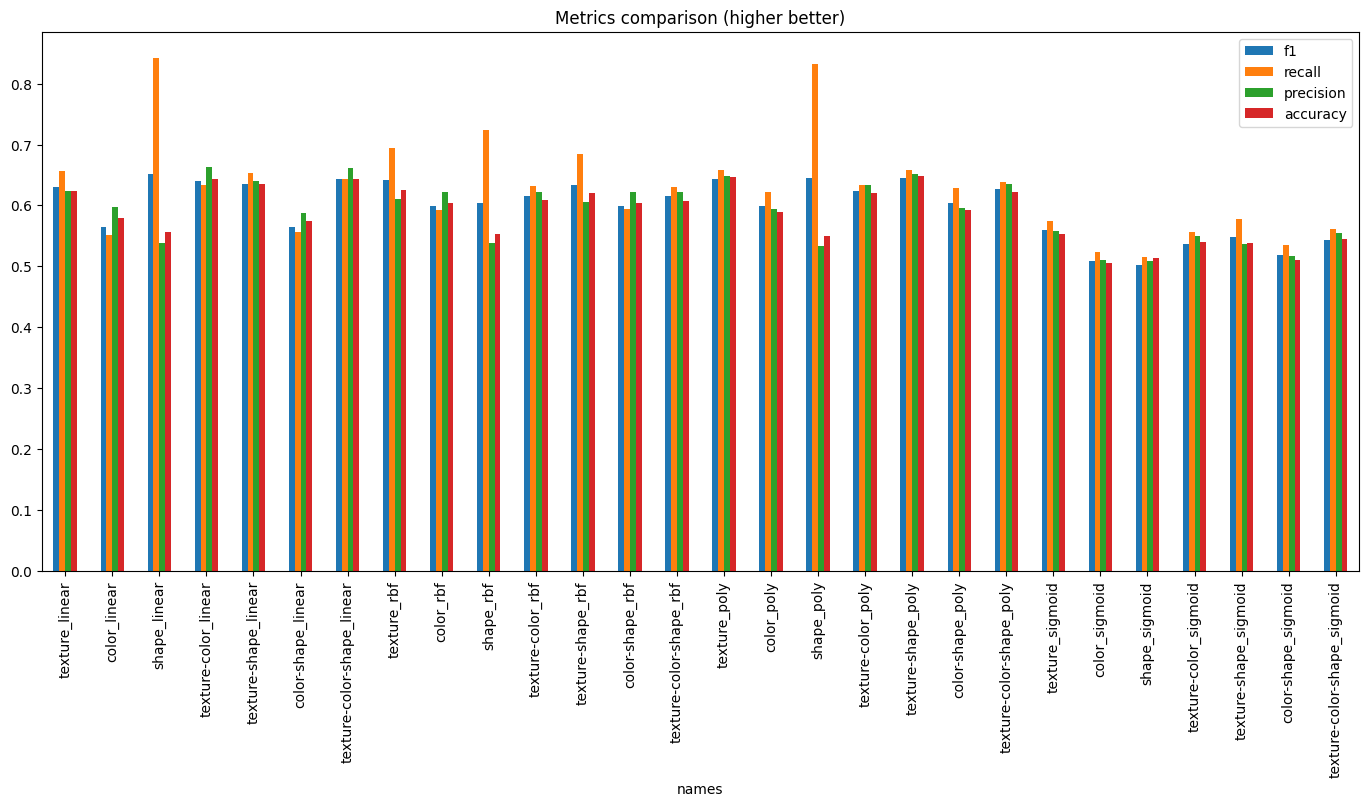

In [18]:
orig_img_compare_df = compare_combined_feature('orig_img_feature.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better)'}, xlabel='names'>

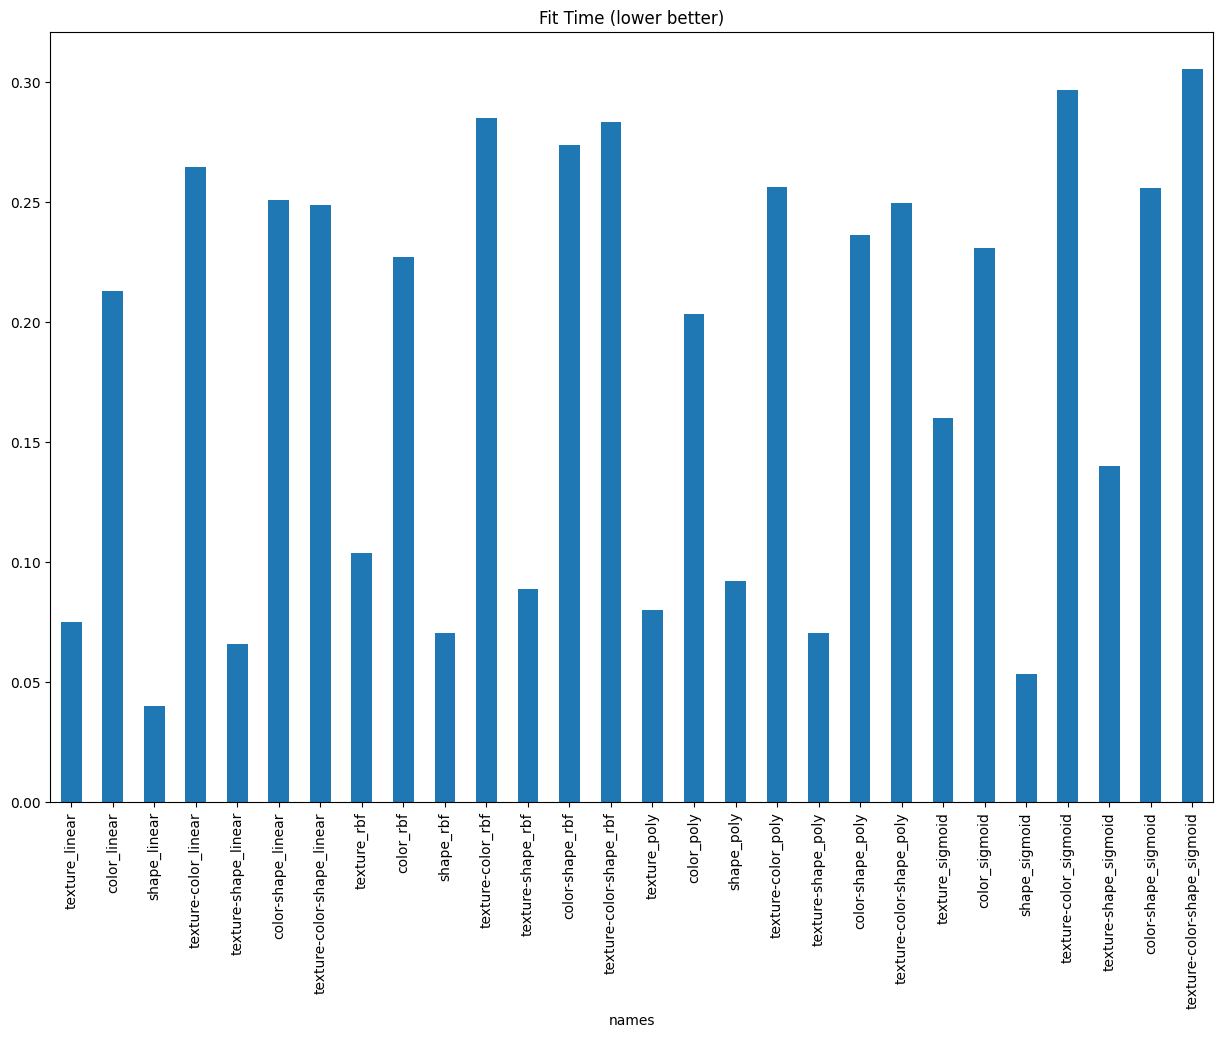

In [19]:
orig_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better)')

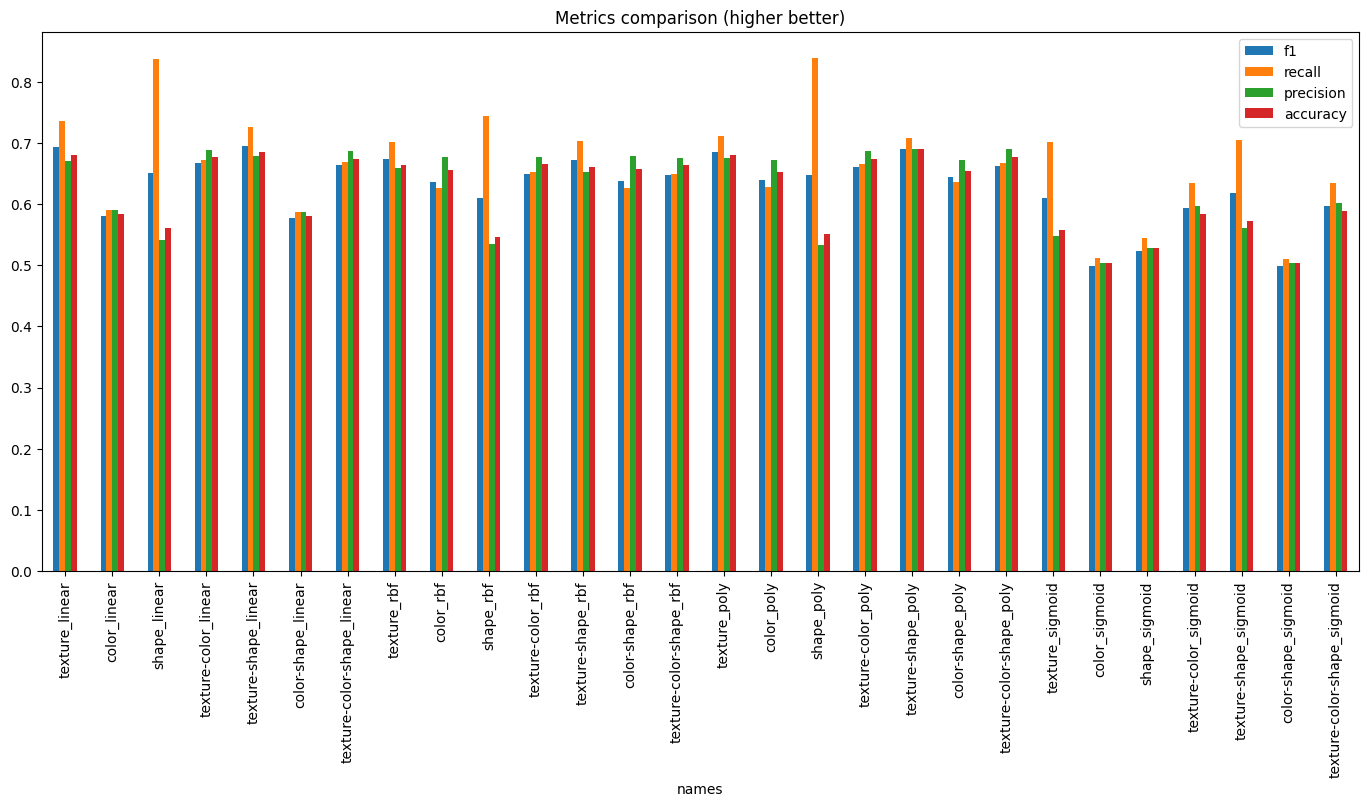

In [20]:
proc_img_compare_df = compare_combined_feature('processed_img_feature.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

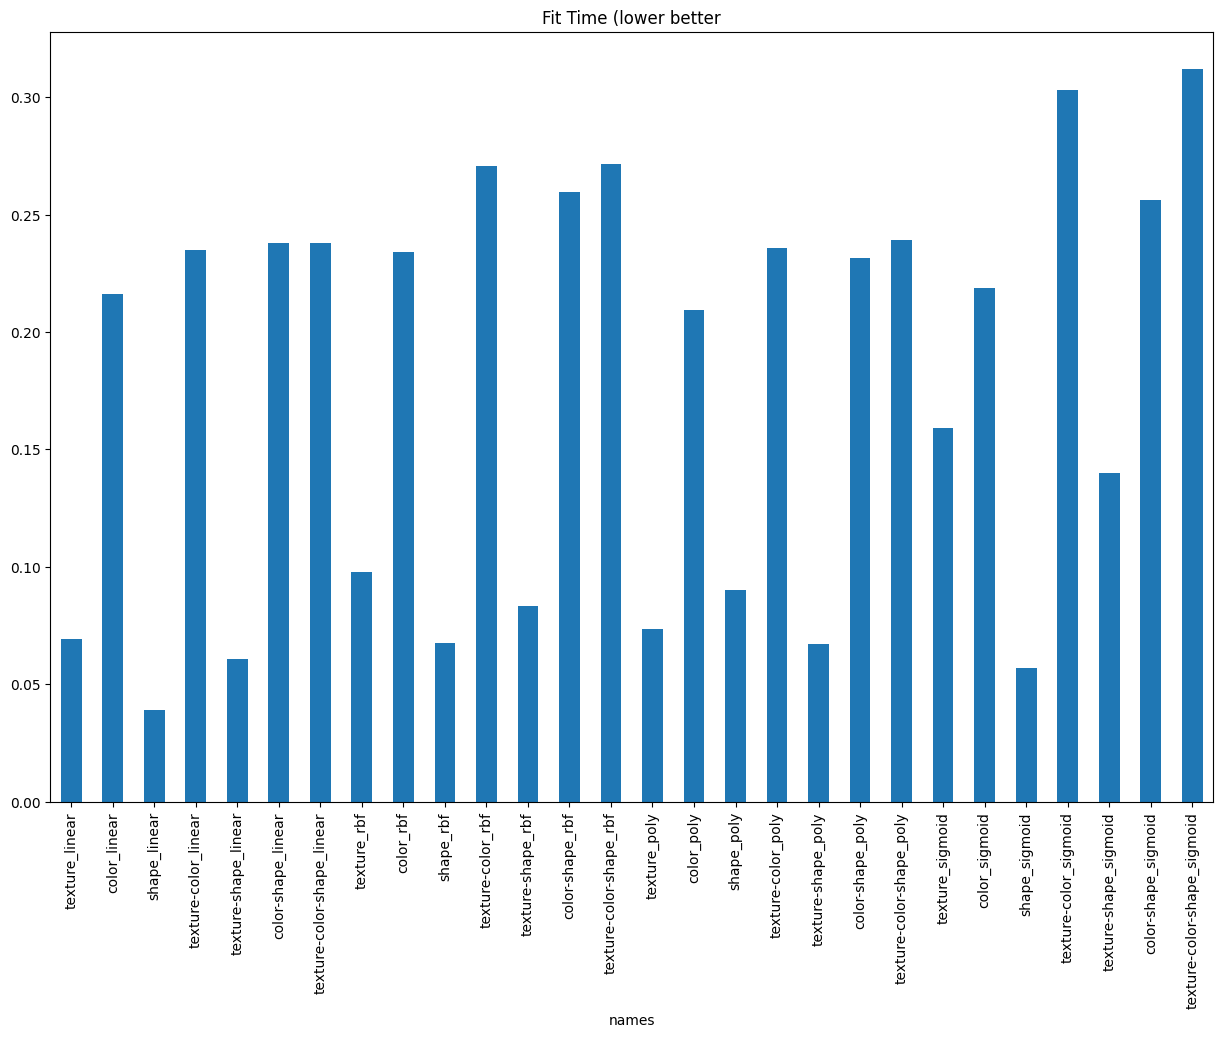

In [21]:
proc_img_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

#### Another Classifiers

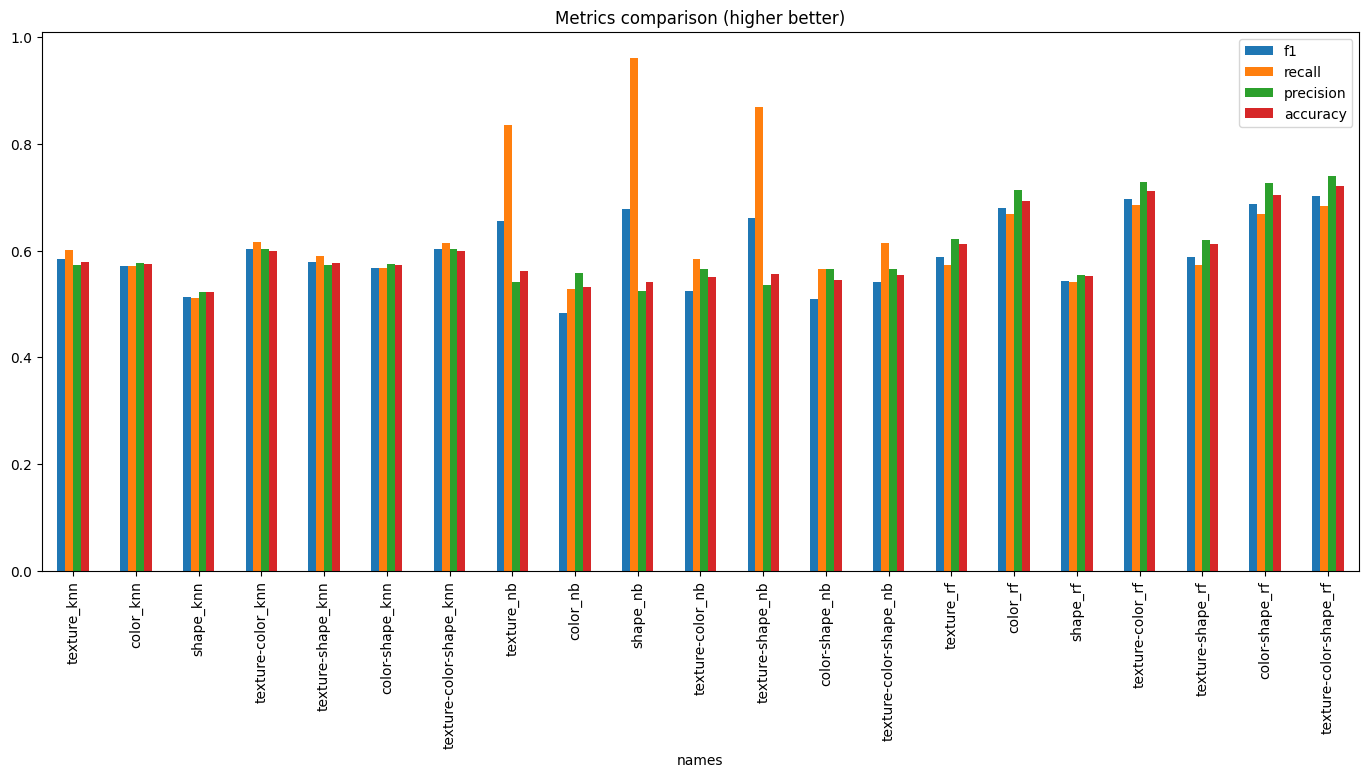

In [22]:
orig_img_classifier_compare_df = compare_combined_feature('orig_img_feature.csv', use_svm=False, classifiers_or_kernels=classifiers)

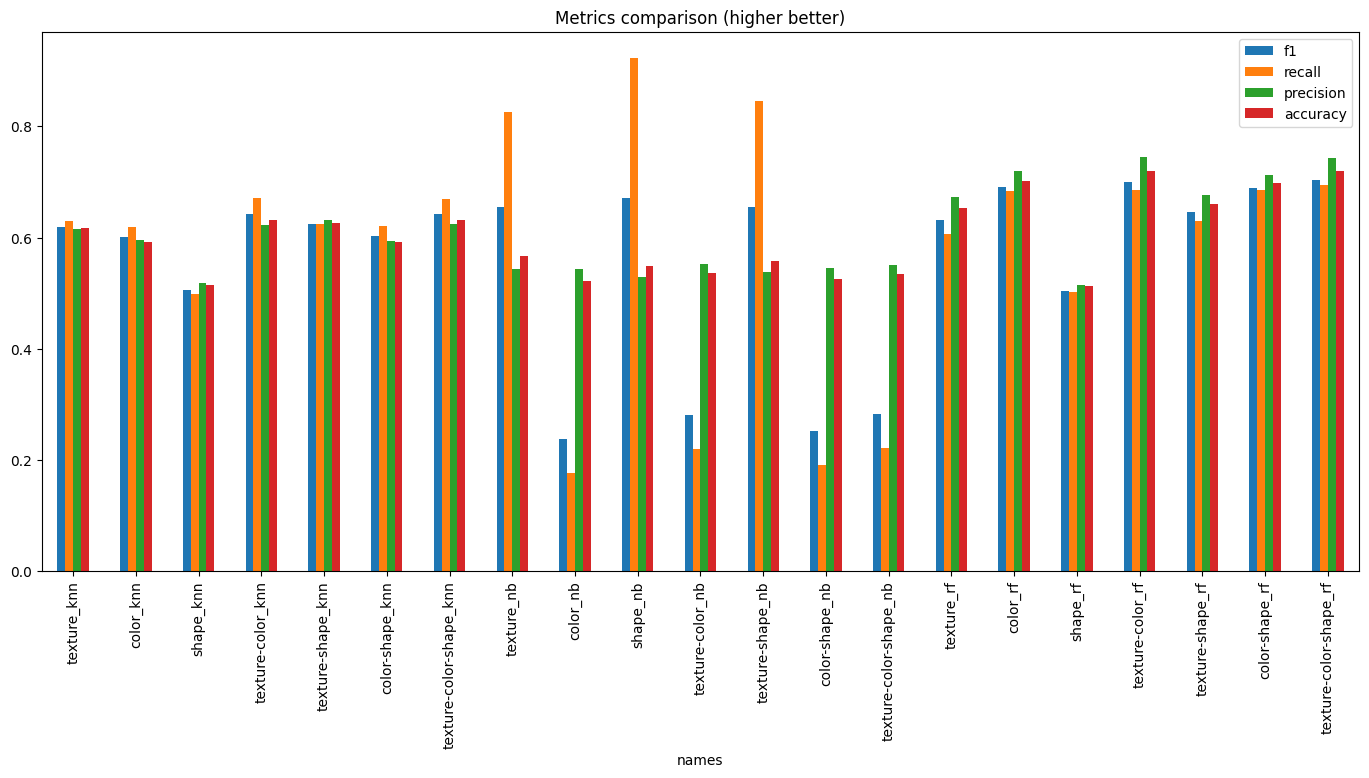

In [23]:
proc_img_compare_df = compare_combined_feature('processed_img_feature.csv', use_svm=False, classifiers_or_kernels=classifiers)

### Reduced Feature

In [24]:
def train_reduced(all_classifiers, feature_files, y, comparison_df, fancy_df, use_svm=True):
    classifiers_map = {'knn': KNeighborsClassifier(3),
                       'nb': GaussianNB(),
                       'rf': RandomForestClassifier()}

    for classifier in all_classifiers:
        for feature_file in feature_files:
            X = pd.read_csv(feature_file)
            name = re.findall(r"s_(.*)\.csv", feature_file)[0].upper()
            if use_svm:
                result = classify_with_svm(X, y, kernel=classifier)
            else:
                result = classify(X, y, classifiers_map[classifier], scoring=metrics)
            comparison_df.loc[len(comparison_df.index)] = [f'{name}_{classifier}',
                                                           result['fit_time'].mean(),
                                                           result['test_f1'].mean(),
                                                           result['test_recall'].mean(),
                                                           result['test_precision'].mean(),
                                                           result['test_accuracy'].mean()]
            fancy_df.loc[classifier, name] = [result['test_f1'].mean(),
                                              result['test_recall'].mean(),
                                              result['test_precision'].mean(),
                                              result['test_accuracy'].mean()]

    return comparison_df, fancy_df

In [25]:
def compare_reduced_feature(csv_file_pattern, use_svm: bool, classifiers_or_kernels=kernels):
    feature_files = glob.glob(os.path.join('data', csv_file_pattern))
    comparison_df = pd.DataFrame(columns=['names', 'fit_time'] + metrics)
    y = pd.read_csv(os.path.join('data', 'orig_img_feature.csv'), usecols=['is_infected']).values.ravel()

    all_feat_sel = [re.findall(r's_(.*)\.csv', x)[0].upper() for x in feature_files]
    fancy_df = create_dataframe(all_feat_sel, classifiers_or_kernels)

    comparison_df, fancy_df = train_reduced(classifiers_or_kernels, feature_files,
                                            y, comparison_df, fancy_df, use_svm=use_svm)

    if use_svm:
        filename = '_classification_result'
    else:
        filename = '_classification_classifiers_result'
    export_name = csv_file_pattern.replace('*', '').replace('.csv', filename)
    export_name = os.path.join('result', export_name)
    # export basic dataframe to csv
    comparison_df.to_csv(export_name + '.csv', index=False)
    # export fancy dataframe to excel
    fancy_df.to_excel(export_name + '.xlsx')

    comparison_df.set_index('names').iloc[:, 1:].plot.bar(figsize=(17, 7), title='Metrics comparison (higher better)')

    return comparison_df

#### Another Classifiers

d:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


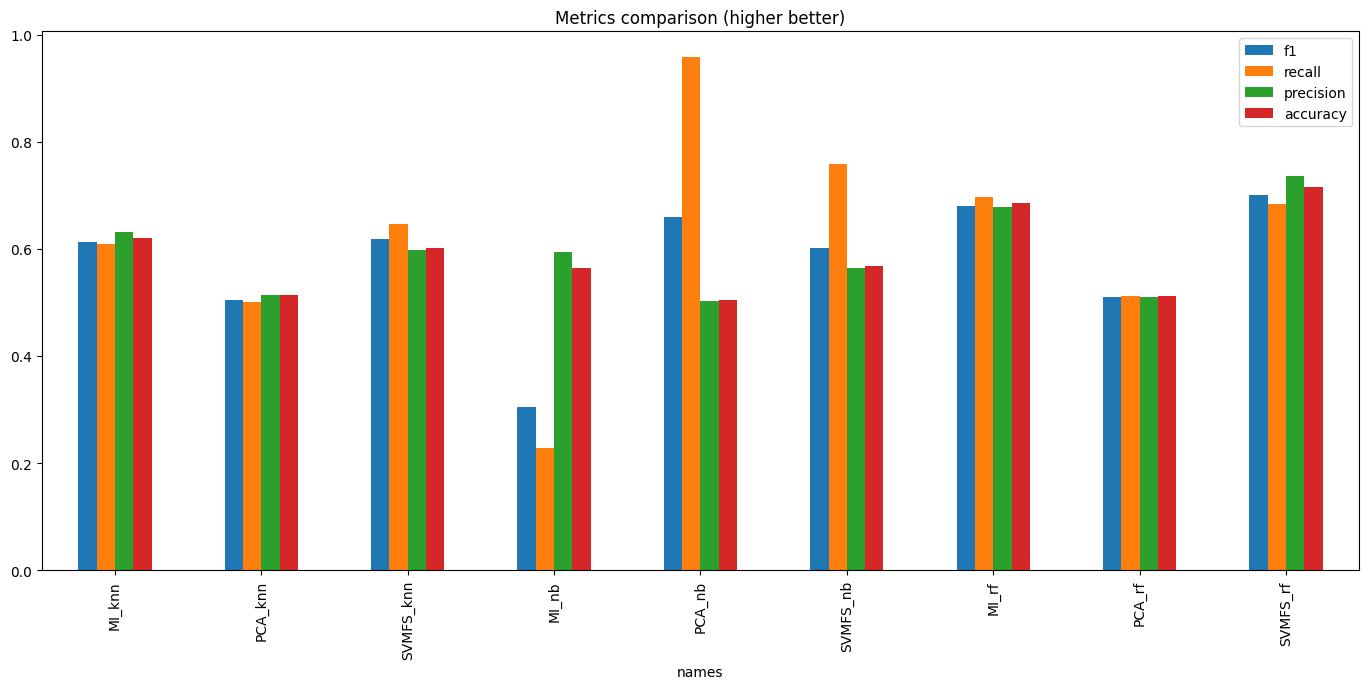

In [26]:
red_orig_compare_classifiers_df = compare_reduced_feature('reduced_*orig*.csv', use_svm=False, classifiers_or_kernels=classifiers)

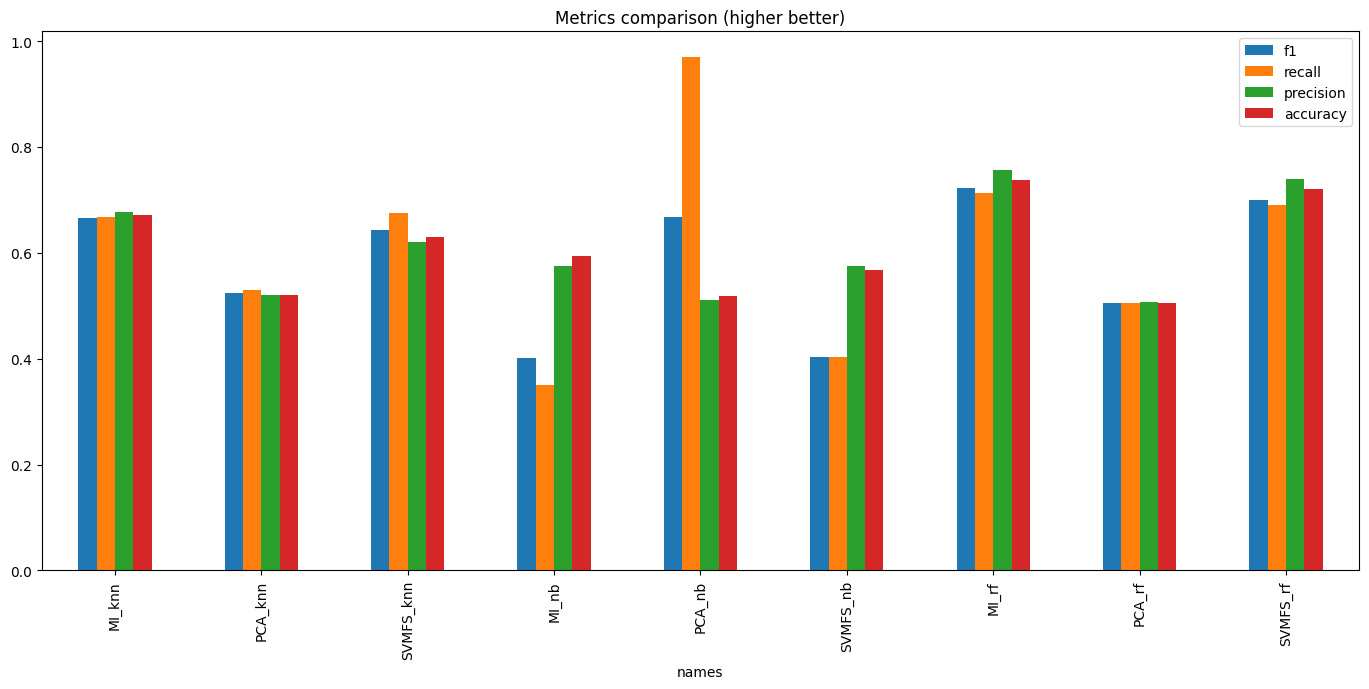

In [27]:
red_proc_compare_classifiers_df = compare_reduced_feature('reduced_*proc*.csv', use_svm=False, classifiers_or_kernels=classifiers)

#### SVM Kernels

d:\Projects\oil-palm-stem\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


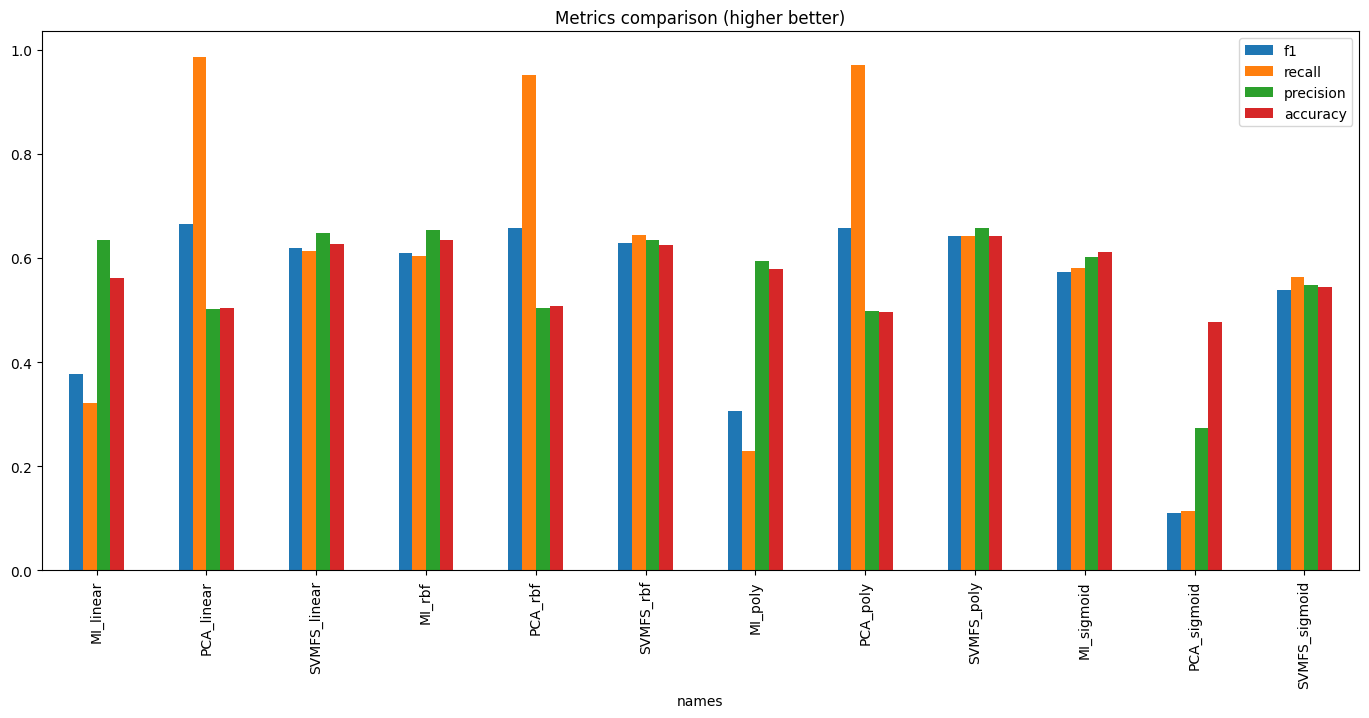

In [28]:
red_orig_compare_df = compare_reduced_feature('reduced_*orig*.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

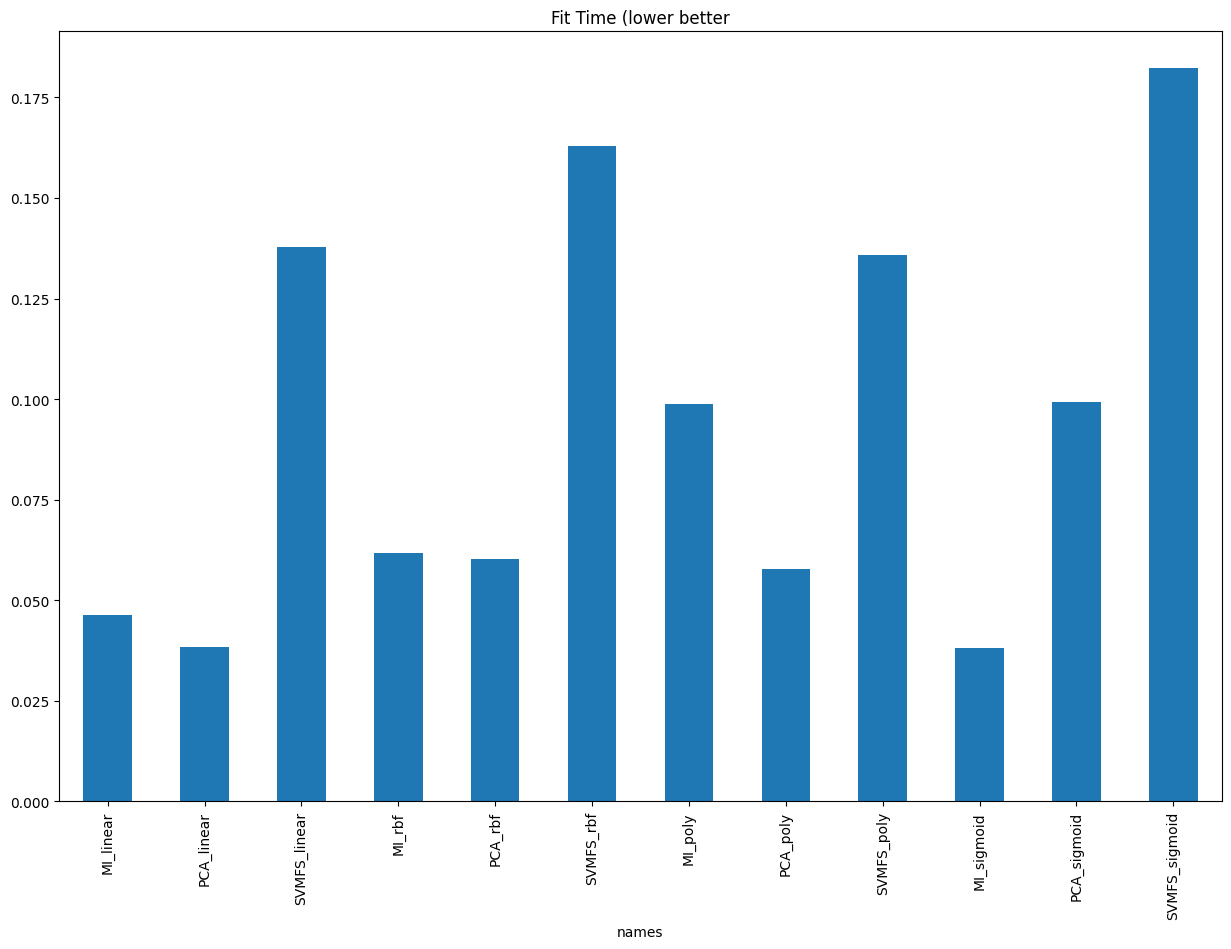

In [29]:
red_orig_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

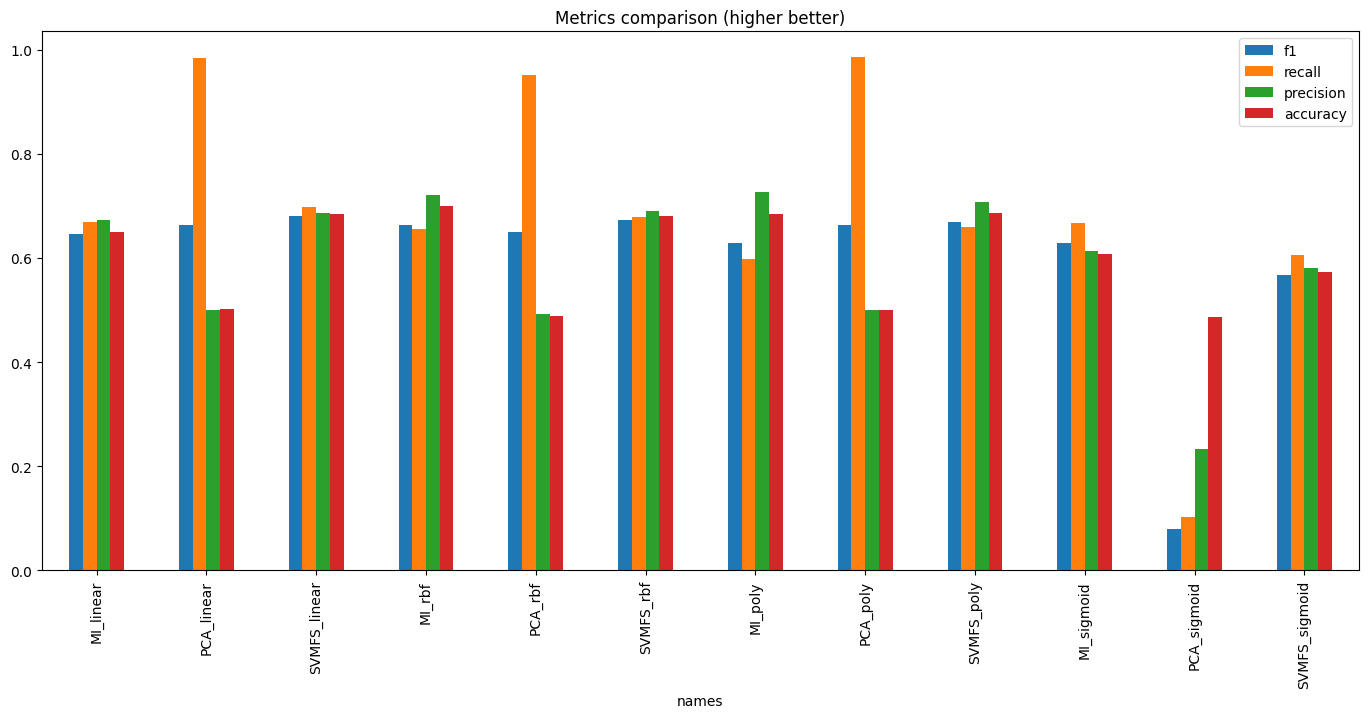

In [30]:
red_proc_compare_df = compare_reduced_feature('reduced_*proc*.csv', use_svm=True)

<Axes: title={'center': 'Fit Time (lower better'}, xlabel='names'>

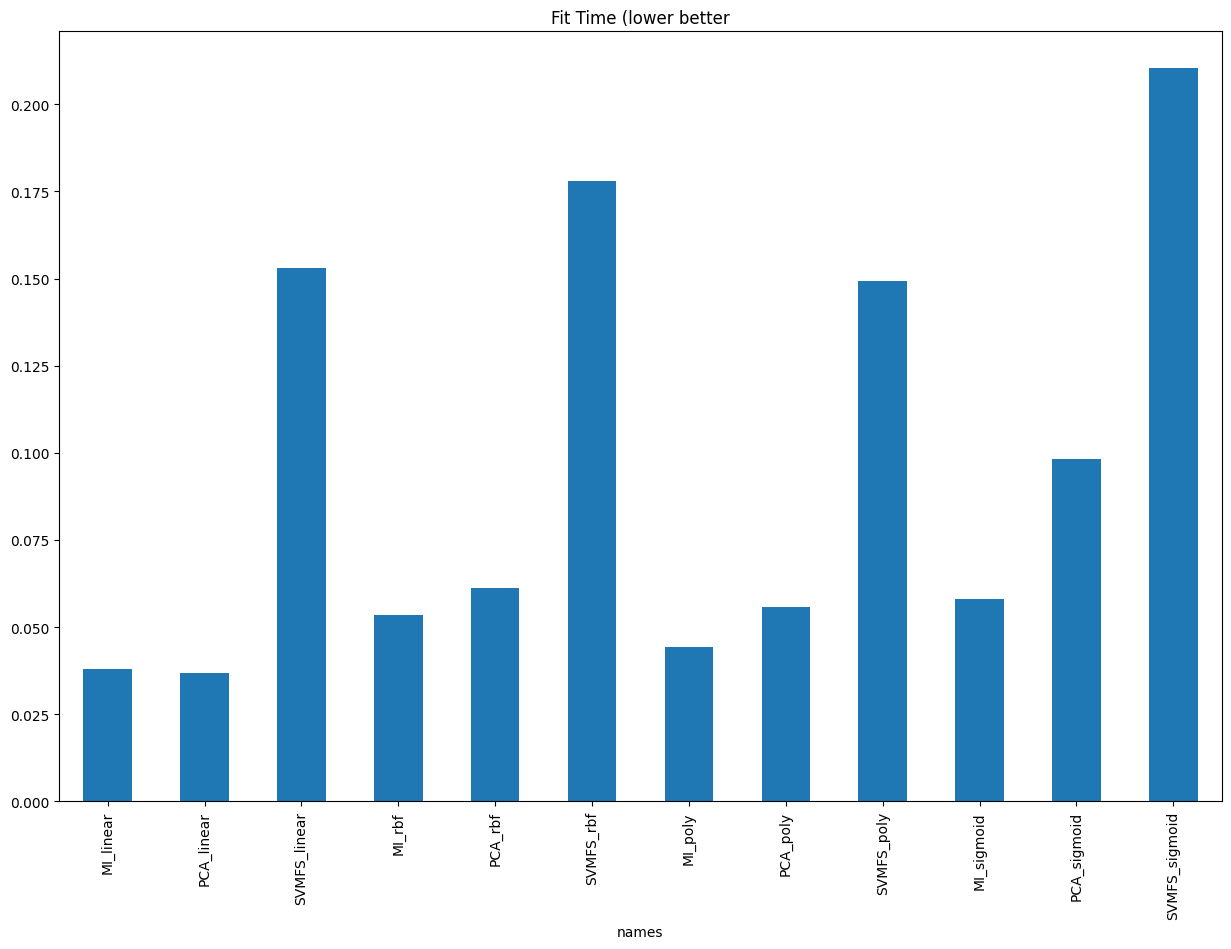

In [31]:
red_proc_compare_df.set_index('names').iloc[:, 0].plot.bar(figsize=(15, 10), title='Fit Time (lower better')

In [32]:
red_proc_compare_classifiers_df

,names,fit_time,f1,recall,precision,accuracy
0,MI_knn,0.004498,0.664863,0.667,0.677167,0.6720
1,PCA_knn,0.002700,0.524043,0.530,0.520494,0.5205
2,SVMFS_knn,0.013200,0.643423,0.675,0.620948,0.6295
3,MI_nb,0.002201,0.400876,0.351,0.575895,0.5945
4,PCA_nb,0.002801,0.668053,0.970,0.509972,0.5175
5,SVMFS_nb,0.018399,0.403527,0.403,0.574511,0.5670
6,MI_rf,0.558799,0.721884,0.713,0.757191,0.7375
7,PCA_rf,0.354808,0.505465,0.506,0.507458,0.5055
8,SVMFS_rf,1.062734,0.699983,0.691,0.739612,0.7210


In [33]:
red_proc_compare_df

,names,fit_time,f1,recall,precision,accuracy
0,MI_linear,0.037889,0.646430,0.669,0.672620,0.6500
1,PCA_linear,0.036914,0.664116,0.985,0.500949,0.5020
2,SVMFS_linear,0.153112,0.681472,0.697,0.687222,0.6845
3,MI_rbf,0.053391,0.663852,0.655,0.720816,0.6995
4,PCA_rbf,0.061102,0.649527,0.952,0.493214,0.4890
5,SVMFS_rbf,0.177901,0.673238,0.679,0.691013,0.6805
6,MI_poly,0.044406,0.628610,0.598,0.726153,0.6850
7,PCA_poly,0.055882,0.663190,0.986,0.499648,0.4995
8,SVMFS_poly,0.149220,0.668691,0.660,0.706923,0.6855
9,MI_sigmoid,0.058191,0.629445,0.667,0.612703,0.6080
